# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

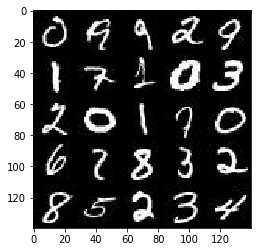

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

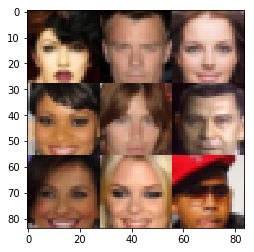

In [3]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
   
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    
    learning_rate=tf.placeholder(tf.float32,None,name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #print("shape of image: {}".format(images.shape))
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator',reuse=reuse):
        #Input Layer 28x28x3
        h1=tf.layers.conv2d(images,64,5,strides=2,padding='same')
        r1=tf.maximum(alpha*h1,h1)
        #16x16x32
        
        h2=tf.layers.conv2d(h1,128,5,strides=2,padding='same')
        bn2=tf.layers.batch_normalization(h2,training=True)
        r2=tf.maximum(alpha*bn2,bn2)
        #8x8x128
        
        h3=tf.layers.conv2d(h2,256,5,strides=2,padding='same')
        bn3=tf.layers.batch_normalization(h3,training=True)
        r3=tf.maximum(alpha*h3,h3)
        #4x4x256
        
        #Flattenning
        flattened=tf.reshape(r3,(-1,4*4*256))
        #logits=tf.layers.dense(flattened,1,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        logits=tf.layers.dense(flattened,1)
        out=tf.sigmoid(logits)      
                
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        #First fully conn layer
        #h1=tf.layers.dense(z,7*7*512,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        h1=tf.layers.dense(z,7*7*512)
        
        #Reshape to begin conv
        h1=tf.reshape(h1,(-1,7,7,512))
        h1=tf.layers.batch_normalization(h1,training=is_train)
        h1=tf.maximum(alpha*h1,h1)
        #4x4x512
        
        h2=tf.layers.conv2d_transpose(h1,256,5,strides=2,padding='same')
        h2=tf.layers.batch_normalization(h2,training=is_train)
        h2=tf.maximum(alpha*h2,h2)
        #8x8x256
        
        h3=tf.layers.conv2d_transpose(h2,128,5,strides=2,padding='same')
        h3=tf.layers.batch_normalization(h3,training=is_train)
        h3=tf.maximum(alpha*h3,h3)
        #16x16x128        
                
        #Output
        logits=tf.layers.conv2d_transpose(h3,out_channel_dim,5,strides=1,padding='same')        
        #28x28x_        
        out=tf.tanh(logits)  
                        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model=generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss=d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars=tf.trainable_variables()
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    
    #out_channel_dim=data_shape[3]
    
    #print("data shape: 1:{0} 2:{1} 3:{2}".format(data_shape[1], data_shape[2], data_shape[3]))
    
    # TODO: Build Model           
    input_real,input_z,lr= model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr=learning_rate
    #return inputs_real, inputs_z, learning_rate_placeholder
    
    d_loss, g_loss= model_loss(input_real, input_z, out_channel_dim)
    #d_loss, g_loss= model_loss(input_real, input_z, data_shape[3])
    #return d_loss,g_loss
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    #return d_train_opt, g_train_opt
        
    #saver=tf.train.Saver()    
    
    samples,losses=[],[]
    steps=0
    
    print_each=10
    show_each=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                
                #Random Noise
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                #Optimizers
                _ =sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z})
                _=sess.run(g_train_opt,feed_dict={input_z:batch_z,input_real:batch_images})
              
                #print(steps)
                if steps % print_each == 0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))    
                    
                #show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                if steps % show_each == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)                  
                                                       
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                                                                                 
                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 1.4191
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 0.0349... Generator Loss: 4.5094
Epoch 1/2... Discriminator Loss: 0.1377... Generator Loss: 3.9900
Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 0.1744... Generator Loss: 5.0059
Epoch 1/2... Discriminator Loss: 2.0487... Generator Loss: 0.4876
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.4124
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.1304


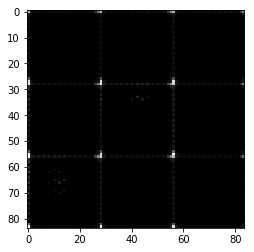

Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 0.5874... Generator Loss: 1.2594
Epoch 1/2... Discriminator Loss: 0.2878... Generator Loss: 2.3058
Epoch 1/2... Discriminator Loss: 2.2232... Generator Loss: 0.5317
Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 2.6329
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.9412
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 1.0089


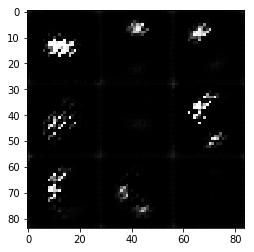

Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.1220
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 1.2784... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.0789... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.8398


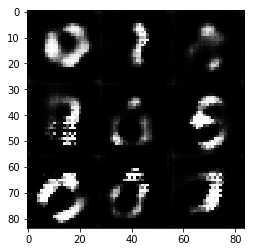

Epoch 1/2... Discriminator Loss: 1.6548... Generator Loss: 0.5619
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.6255
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.7476


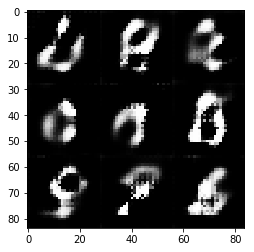

Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.6687
Epoch 2/2... Discriminator Loss: 1.4092... Generator Loss: 0.7213


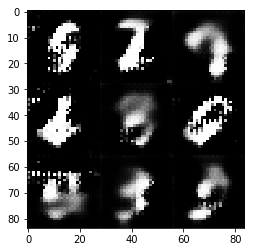

Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.6874
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.7672
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.6996


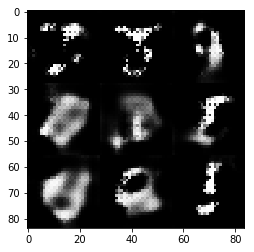

Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.7838


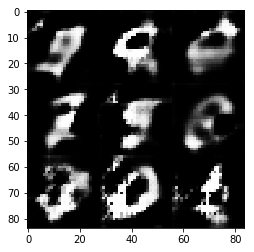

Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.8672


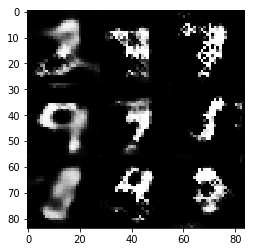

Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.5127... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.8180


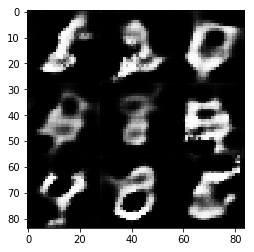

Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.9128


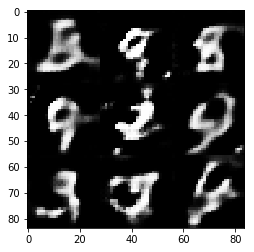

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 1.8345... Generator Loss: 0.2268
Epoch 1/3... Discriminator Loss: 0.2150... Generator Loss: 3.5756
Epoch 1/3... Discriminator Loss: 0.1649... Generator Loss: 3.7157
Epoch 1/3... Discriminator Loss: 0.1469... Generator Loss: 2.7432
Epoch 1/3... Discriminator Loss: 0.4410... Generator Loss: 1.4366
Epoch 1/3... Discriminator Loss: 0.1449... Generator Loss: 5.6729
Epoch 1/3... Discriminator Loss: 0.1227... Generator Loss: 3.1932
Epoch 1/3... Discriminator Loss: 0.2568... Generator Loss: 3.7391
Epoch 1/3... Discriminator Loss: 0.5594... Generator Loss: 1.0998
Epoch 1/3... Discriminator Loss: 0.1923... Generator Loss: 3.5685


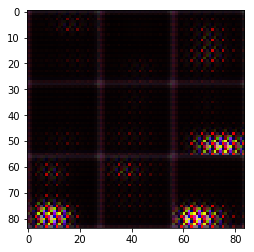

Epoch 1/3... Discriminator Loss: 0.2578... Generator Loss: 3.8252
Epoch 1/3... Discriminator Loss: 0.1010... Generator Loss: 4.0613
Epoch 1/3... Discriminator Loss: 0.6552... Generator Loss: 1.5045
Epoch 1/3... Discriminator Loss: 0.2133... Generator Loss: 3.2180
Epoch 1/3... Discriminator Loss: 0.3718... Generator Loss: 2.0504
Epoch 1/3... Discriminator Loss: 0.6336... Generator Loss: 1.4701
Epoch 1/3... Discriminator Loss: 0.3256... Generator Loss: 2.6530
Epoch 1/3... Discriminator Loss: 0.9717... Generator Loss: 1.1592
Epoch 1/3... Discriminator Loss: 0.4855... Generator Loss: 1.9392
Epoch 1/3... Discriminator Loss: 0.2807... Generator Loss: 2.2456


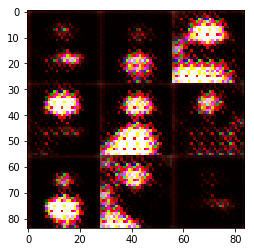

Epoch 1/3... Discriminator Loss: 1.1445... Generator Loss: 1.4660
Epoch 1/3... Discriminator Loss: 0.6557... Generator Loss: 1.7724
Epoch 1/3... Discriminator Loss: 0.8377... Generator Loss: 1.1900
Epoch 1/3... Discriminator Loss: 0.7542... Generator Loss: 1.7294
Epoch 1/3... Discriminator Loss: 0.7933... Generator Loss: 1.8069
Epoch 1/3... Discriminator Loss: 0.8562... Generator Loss: 1.7777
Epoch 1/3... Discriminator Loss: 0.8022... Generator Loss: 1.7101
Epoch 1/3... Discriminator Loss: 0.7496... Generator Loss: 1.5993
Epoch 1/3... Discriminator Loss: 0.7181... Generator Loss: 1.7722
Epoch 1/3... Discriminator Loss: 0.7127... Generator Loss: 1.8898


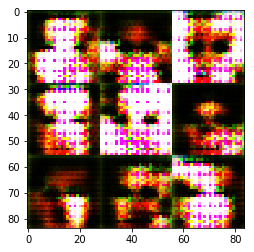

Epoch 1/3... Discriminator Loss: 0.9527... Generator Loss: 1.5313
Epoch 1/3... Discriminator Loss: 0.6735... Generator Loss: 1.8221
Epoch 1/3... Discriminator Loss: 1.3103... Generator Loss: 1.3494
Epoch 1/3... Discriminator Loss: 0.4783... Generator Loss: 1.9896
Epoch 1/3... Discriminator Loss: 0.9297... Generator Loss: 1.3197
Epoch 1/3... Discriminator Loss: 0.5894... Generator Loss: 1.8743
Epoch 1/3... Discriminator Loss: 0.8501... Generator Loss: 1.9279
Epoch 1/3... Discriminator Loss: 0.5602... Generator Loss: 1.7328
Epoch 1/3... Discriminator Loss: 0.5609... Generator Loss: 2.3139
Epoch 1/3... Discriminator Loss: 0.4167... Generator Loss: 2.9018


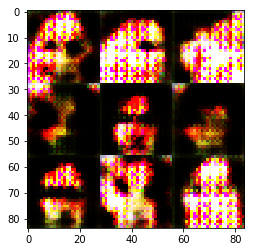

Epoch 1/3... Discriminator Loss: 0.6970... Generator Loss: 1.4122
Epoch 1/3... Discriminator Loss: 0.5244... Generator Loss: 2.6903
Epoch 1/3... Discriminator Loss: 1.0863... Generator Loss: 1.4161
Epoch 1/3... Discriminator Loss: 0.4225... Generator Loss: 2.0117
Epoch 1/3... Discriminator Loss: 1.3373... Generator Loss: 2.6549
Epoch 1/3... Discriminator Loss: 0.7477... Generator Loss: 1.7737
Epoch 1/3... Discriminator Loss: 1.0602... Generator Loss: 1.2520
Epoch 1/3... Discriminator Loss: 0.8500... Generator Loss: 1.4120
Epoch 1/3... Discriminator Loss: 0.7005... Generator Loss: 1.8635
Epoch 1/3... Discriminator Loss: 1.1996... Generator Loss: 1.4495


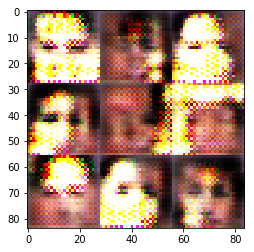

Epoch 1/3... Discriminator Loss: 0.8264... Generator Loss: 1.4408
Epoch 1/3... Discriminator Loss: 0.7952... Generator Loss: 1.4728
Epoch 1/3... Discriminator Loss: 0.8075... Generator Loss: 1.3312
Epoch 1/3... Discriminator Loss: 0.8257... Generator Loss: 1.6246
Epoch 1/3... Discriminator Loss: 1.0346... Generator Loss: 1.1913
Epoch 1/3... Discriminator Loss: 1.1181... Generator Loss: 1.0576
Epoch 1/3... Discriminator Loss: 0.8181... Generator Loss: 1.6394
Epoch 1/3... Discriminator Loss: 1.0567... Generator Loss: 1.1628
Epoch 1/3... Discriminator Loss: 1.1298... Generator Loss: 1.0626
Epoch 1/3... Discriminator Loss: 0.7992... Generator Loss: 1.7997


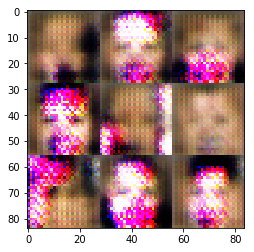

Epoch 1/3... Discriminator Loss: 0.7081... Generator Loss: 1.7573
Epoch 1/3... Discriminator Loss: 1.5361... Generator Loss: 0.8132
Epoch 1/3... Discriminator Loss: 0.9389... Generator Loss: 1.0383
Epoch 1/3... Discriminator Loss: 0.9394... Generator Loss: 1.0342
Epoch 1/3... Discriminator Loss: 1.1609... Generator Loss: 0.8905
Epoch 1/3... Discriminator Loss: 0.9430... Generator Loss: 1.1646
Epoch 1/3... Discriminator Loss: 1.2408... Generator Loss: 1.0015
Epoch 1/3... Discriminator Loss: 0.9816... Generator Loss: 1.3554
Epoch 1/3... Discriminator Loss: 1.1094... Generator Loss: 1.2852
Epoch 1/3... Discriminator Loss: 0.9850... Generator Loss: 1.1834


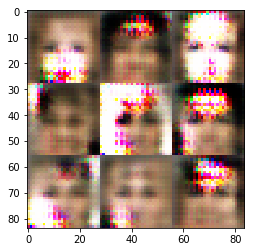

Epoch 1/3... Discriminator Loss: 1.0195... Generator Loss: 1.3374
Epoch 1/3... Discriminator Loss: 0.8758... Generator Loss: 1.3474
Epoch 1/3... Discriminator Loss: 1.0486... Generator Loss: 1.3552
Epoch 1/3... Discriminator Loss: 0.7908... Generator Loss: 1.5692
Epoch 1/3... Discriminator Loss: 0.9999... Generator Loss: 1.3500
Epoch 1/3... Discriminator Loss: 1.0144... Generator Loss: 1.0922
Epoch 1/3... Discriminator Loss: 1.3130... Generator Loss: 0.6299
Epoch 1/3... Discriminator Loss: 1.1549... Generator Loss: 0.8051
Epoch 1/3... Discriminator Loss: 0.9036... Generator Loss: 1.3388
Epoch 1/3... Discriminator Loss: 1.2814... Generator Loss: 1.1517


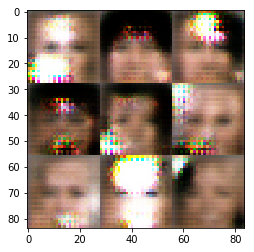

Epoch 1/3... Discriminator Loss: 1.1209... Generator Loss: 1.1477
Epoch 1/3... Discriminator Loss: 0.9596... Generator Loss: 0.8470
Epoch 1/3... Discriminator Loss: 0.9792... Generator Loss: 1.3033
Epoch 1/3... Discriminator Loss: 1.2170... Generator Loss: 0.9373
Epoch 1/3... Discriminator Loss: 1.0443... Generator Loss: 1.1918
Epoch 1/3... Discriminator Loss: 1.0323... Generator Loss: 1.7407
Epoch 1/3... Discriminator Loss: 0.8377... Generator Loss: 1.8600
Epoch 1/3... Discriminator Loss: 1.0153... Generator Loss: 1.1677
Epoch 1/3... Discriminator Loss: 1.0601... Generator Loss: 1.0151
Epoch 1/3... Discriminator Loss: 1.0187... Generator Loss: 0.9235


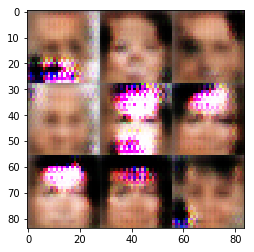

Epoch 1/3... Discriminator Loss: 0.9202... Generator Loss: 1.3085
Epoch 1/3... Discriminator Loss: 1.1436... Generator Loss: 0.8865
Epoch 1/3... Discriminator Loss: 0.9484... Generator Loss: 1.2070
Epoch 1/3... Discriminator Loss: 1.1177... Generator Loss: 1.1347
Epoch 1/3... Discriminator Loss: 1.3485... Generator Loss: 1.0563
Epoch 1/3... Discriminator Loss: 1.0843... Generator Loss: 1.0528
Epoch 1/3... Discriminator Loss: 1.1249... Generator Loss: 1.0206
Epoch 1/3... Discriminator Loss: 1.2049... Generator Loss: 1.2169
Epoch 1/3... Discriminator Loss: 1.1830... Generator Loss: 0.9330
Epoch 1/3... Discriminator Loss: 1.1683... Generator Loss: 1.2612


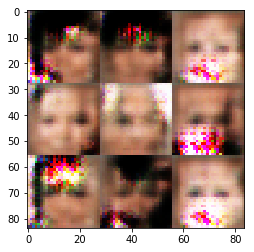

Epoch 1/3... Discriminator Loss: 1.1015... Generator Loss: 0.9661
Epoch 1/3... Discriminator Loss: 1.0000... Generator Loss: 1.2955
Epoch 1/3... Discriminator Loss: 0.7122... Generator Loss: 2.8650
Epoch 1/3... Discriminator Loss: 1.2493... Generator Loss: 0.7582
Epoch 1/3... Discriminator Loss: 1.0128... Generator Loss: 1.2572
Epoch 1/3... Discriminator Loss: 0.9500... Generator Loss: 1.3567
Epoch 1/3... Discriminator Loss: 1.1329... Generator Loss: 0.8824
Epoch 1/3... Discriminator Loss: 1.0871... Generator Loss: 1.0751
Epoch 1/3... Discriminator Loss: 1.1525... Generator Loss: 0.9976
Epoch 1/3... Discriminator Loss: 1.1775... Generator Loss: 1.0736


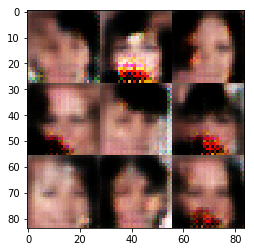

Epoch 1/3... Discriminator Loss: 1.0164... Generator Loss: 1.2875
Epoch 1/3... Discriminator Loss: 0.9528... Generator Loss: 1.2660
Epoch 1/3... Discriminator Loss: 1.1668... Generator Loss: 1.3484
Epoch 1/3... Discriminator Loss: 1.0704... Generator Loss: 1.1325
Epoch 1/3... Discriminator Loss: 1.0513... Generator Loss: 1.1953
Epoch 1/3... Discriminator Loss: 1.3188... Generator Loss: 0.9085
Epoch 1/3... Discriminator Loss: 1.1828... Generator Loss: 1.0214
Epoch 1/3... Discriminator Loss: 1.2728... Generator Loss: 0.9103
Epoch 1/3... Discriminator Loss: 1.1166... Generator Loss: 1.0971
Epoch 1/3... Discriminator Loss: 1.1205... Generator Loss: 0.9976


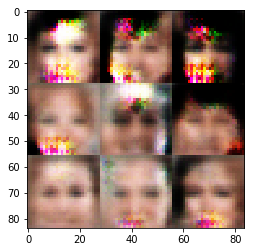

Epoch 1/3... Discriminator Loss: 1.2522... Generator Loss: 0.8986
Epoch 1/3... Discriminator Loss: 1.1516... Generator Loss: 0.9471
Epoch 1/3... Discriminator Loss: 1.0628... Generator Loss: 1.0590
Epoch 1/3... Discriminator Loss: 1.0331... Generator Loss: 1.1172
Epoch 1/3... Discriminator Loss: 1.1001... Generator Loss: 0.8962
Epoch 1/3... Discriminator Loss: 1.1191... Generator Loss: 1.0691
Epoch 1/3... Discriminator Loss: 1.0851... Generator Loss: 0.9377
Epoch 1/3... Discriminator Loss: 1.1840... Generator Loss: 0.8367
Epoch 1/3... Discriminator Loss: 1.1438... Generator Loss: 0.7063
Epoch 1/3... Discriminator Loss: 1.1507... Generator Loss: 0.9765


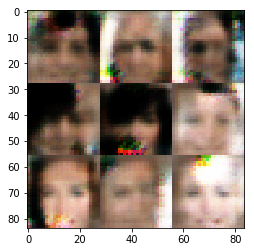

Epoch 1/3... Discriminator Loss: 1.1168... Generator Loss: 0.9780
Epoch 1/3... Discriminator Loss: 1.2042... Generator Loss: 0.9397
Epoch 1/3... Discriminator Loss: 1.2219... Generator Loss: 0.9633
Epoch 1/3... Discriminator Loss: 1.1888... Generator Loss: 1.0074
Epoch 1/3... Discriminator Loss: 1.1862... Generator Loss: 0.8260
Epoch 1/3... Discriminator Loss: 1.1822... Generator Loss: 0.8842
Epoch 1/3... Discriminator Loss: 1.1099... Generator Loss: 1.0117
Epoch 1/3... Discriminator Loss: 1.2448... Generator Loss: 0.9751
Epoch 1/3... Discriminator Loss: 1.3827... Generator Loss: 0.7964
Epoch 1/3... Discriminator Loss: 1.1953... Generator Loss: 0.8530


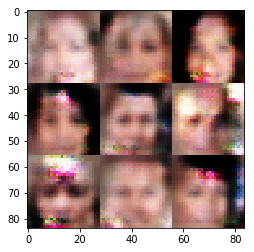

Epoch 1/3... Discriminator Loss: 1.3168... Generator Loss: 0.7855
Epoch 1/3... Discriminator Loss: 1.1546... Generator Loss: 0.8676
Epoch 1/3... Discriminator Loss: 1.2331... Generator Loss: 0.9319
Epoch 1/3... Discriminator Loss: 1.2243... Generator Loss: 0.8282
Epoch 1/3... Discriminator Loss: 1.2910... Generator Loss: 0.7399
Epoch 1/3... Discriminator Loss: 1.0637... Generator Loss: 1.6096
Epoch 1/3... Discriminator Loss: 1.2067... Generator Loss: 0.8479
Epoch 1/3... Discriminator Loss: 1.1123... Generator Loss: 1.0115
Epoch 1/3... Discriminator Loss: 1.2554... Generator Loss: 0.7712
Epoch 1/3... Discriminator Loss: 1.1524... Generator Loss: 0.9739


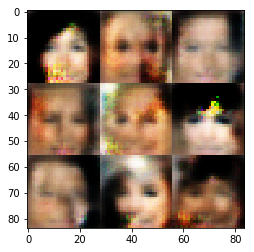

Epoch 1/3... Discriminator Loss: 1.2746... Generator Loss: 0.8123
Epoch 1/3... Discriminator Loss: 1.2945... Generator Loss: 0.7642
Epoch 1/3... Discriminator Loss: 1.1705... Generator Loss: 1.1595
Epoch 1/3... Discriminator Loss: 1.2552... Generator Loss: 0.9009
Epoch 1/3... Discriminator Loss: 1.2647... Generator Loss: 0.7899
Epoch 1/3... Discriminator Loss: 1.2217... Generator Loss: 0.8430
Epoch 1/3... Discriminator Loss: 1.1544... Generator Loss: 1.2266
Epoch 1/3... Discriminator Loss: 1.3061... Generator Loss: 0.8691
Epoch 2/3... Discriminator Loss: 1.2823... Generator Loss: 0.6875
Epoch 2/3... Discriminator Loss: 1.2131... Generator Loss: 1.0014


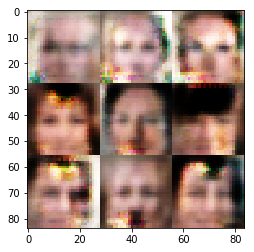

Epoch 2/3... Discriminator Loss: 1.2580... Generator Loss: 0.8434
Epoch 2/3... Discriminator Loss: 1.2221... Generator Loss: 0.8763
Epoch 2/3... Discriminator Loss: 1.2805... Generator Loss: 1.0056
Epoch 2/3... Discriminator Loss: 1.1301... Generator Loss: 0.8138
Epoch 2/3... Discriminator Loss: 1.1165... Generator Loss: 0.9596
Epoch 2/3... Discriminator Loss: 1.2199... Generator Loss: 1.1161
Epoch 2/3... Discriminator Loss: 1.2207... Generator Loss: 0.8475
Epoch 2/3... Discriminator Loss: 1.2199... Generator Loss: 0.8454
Epoch 2/3... Discriminator Loss: 1.2015... Generator Loss: 0.7931
Epoch 2/3... Discriminator Loss: 1.1848... Generator Loss: 0.9122


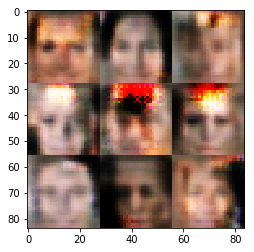

Epoch 2/3... Discriminator Loss: 1.2862... Generator Loss: 0.7374
Epoch 2/3... Discriminator Loss: 1.2559... Generator Loss: 0.6725
Epoch 2/3... Discriminator Loss: 1.2099... Generator Loss: 0.9810
Epoch 2/3... Discriminator Loss: 1.2936... Generator Loss: 0.7536
Epoch 2/3... Discriminator Loss: 1.1896... Generator Loss: 0.9625
Epoch 2/3... Discriminator Loss: 1.2381... Generator Loss: 0.7776
Epoch 2/3... Discriminator Loss: 1.2527... Generator Loss: 0.8426
Epoch 2/3... Discriminator Loss: 1.3649... Generator Loss: 0.6888
Epoch 2/3... Discriminator Loss: 1.2538... Generator Loss: 0.8200
Epoch 2/3... Discriminator Loss: 1.2831... Generator Loss: 1.0410


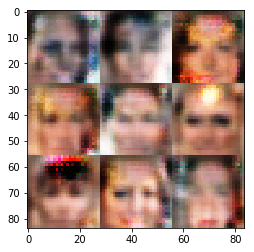

Epoch 2/3... Discriminator Loss: 1.3230... Generator Loss: 0.8784
Epoch 2/3... Discriminator Loss: 1.2333... Generator Loss: 0.9274
Epoch 2/3... Discriminator Loss: 1.2519... Generator Loss: 0.9205
Epoch 2/3... Discriminator Loss: 1.2220... Generator Loss: 0.8459
Epoch 2/3... Discriminator Loss: 1.1908... Generator Loss: 0.9343
Epoch 2/3... Discriminator Loss: 1.2121... Generator Loss: 0.8350
Epoch 2/3... Discriminator Loss: 1.3165... Generator Loss: 0.8071
Epoch 2/3... Discriminator Loss: 1.3819... Generator Loss: 0.8481
Epoch 2/3... Discriminator Loss: 1.2122... Generator Loss: 0.8637
Epoch 2/3... Discriminator Loss: 1.2841... Generator Loss: 1.0185


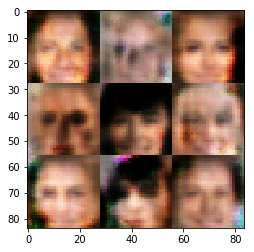

Epoch 2/3... Discriminator Loss: 1.2678... Generator Loss: 0.7637
Epoch 2/3... Discriminator Loss: 1.2850... Generator Loss: 0.9239
Epoch 2/3... Discriminator Loss: 1.1564... Generator Loss: 0.9403
Epoch 2/3... Discriminator Loss: 1.2444... Generator Loss: 0.9033
Epoch 2/3... Discriminator Loss: 1.3320... Generator Loss: 0.7447
Epoch 2/3... Discriminator Loss: 1.0247... Generator Loss: 1.0509
Epoch 2/3... Discriminator Loss: 1.2772... Generator Loss: 0.9078
Epoch 2/3... Discriminator Loss: 1.2836... Generator Loss: 0.7348
Epoch 2/3... Discriminator Loss: 1.2362... Generator Loss: 0.8013
Epoch 2/3... Discriminator Loss: 1.3787... Generator Loss: 0.8166


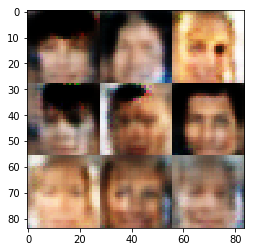

Epoch 2/3... Discriminator Loss: 1.1610... Generator Loss: 0.9561
Epoch 2/3... Discriminator Loss: 1.2913... Generator Loss: 0.7271
Epoch 2/3... Discriminator Loss: 1.3413... Generator Loss: 0.7917
Epoch 2/3... Discriminator Loss: 1.4586... Generator Loss: 0.9602
Epoch 2/3... Discriminator Loss: 1.2442... Generator Loss: 1.1577
Epoch 2/3... Discriminator Loss: 1.4022... Generator Loss: 0.9745
Epoch 2/3... Discriminator Loss: 1.2134... Generator Loss: 0.8943
Epoch 2/3... Discriminator Loss: 1.3681... Generator Loss: 0.8843
Epoch 2/3... Discriminator Loss: 1.3539... Generator Loss: 0.9787
Epoch 2/3... Discriminator Loss: 1.1396... Generator Loss: 0.9813


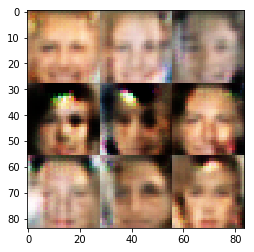

Epoch 2/3... Discriminator Loss: 1.1968... Generator Loss: 0.8224
Epoch 2/3... Discriminator Loss: 1.2655... Generator Loss: 1.0508
Epoch 2/3... Discriminator Loss: 1.3335... Generator Loss: 1.0013
Epoch 2/3... Discriminator Loss: 1.2570... Generator Loss: 0.8871
Epoch 2/3... Discriminator Loss: 1.3207... Generator Loss: 0.7280
Epoch 2/3... Discriminator Loss: 1.3069... Generator Loss: 0.7668
Epoch 2/3... Discriminator Loss: 1.2095... Generator Loss: 0.8037
Epoch 2/3... Discriminator Loss: 1.2127... Generator Loss: 0.7975
Epoch 2/3... Discriminator Loss: 1.2684... Generator Loss: 0.8833
Epoch 2/3... Discriminator Loss: 1.2107... Generator Loss: 0.8233


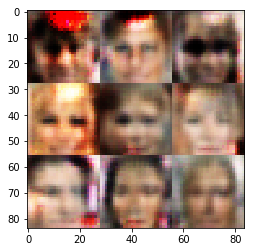

Epoch 2/3... Discriminator Loss: 1.2589... Generator Loss: 0.9319
Epoch 2/3... Discriminator Loss: 2.0150... Generator Loss: 1.3055
Epoch 2/3... Discriminator Loss: 1.2876... Generator Loss: 0.6835
Epoch 2/3... Discriminator Loss: 1.1817... Generator Loss: 0.8962
Epoch 2/3... Discriminator Loss: 1.2722... Generator Loss: 0.8516
Epoch 2/3... Discriminator Loss: 1.2917... Generator Loss: 0.8039
Epoch 2/3... Discriminator Loss: 1.2906... Generator Loss: 0.7895
Epoch 2/3... Discriminator Loss: 1.1498... Generator Loss: 1.0154
Epoch 2/3... Discriminator Loss: 1.3141... Generator Loss: 0.8013
Epoch 2/3... Discriminator Loss: 1.3643... Generator Loss: 0.6842


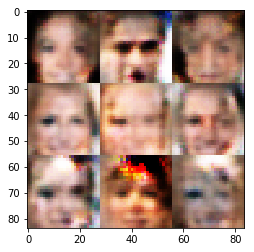

Epoch 2/3... Discriminator Loss: 1.2074... Generator Loss: 0.9117
Epoch 2/3... Discriminator Loss: 1.2640... Generator Loss: 0.7536
Epoch 2/3... Discriminator Loss: 1.3166... Generator Loss: 0.6818
Epoch 2/3... Discriminator Loss: 1.2094... Generator Loss: 0.8849
Epoch 2/3... Discriminator Loss: 1.3193... Generator Loss: 0.7168
Epoch 2/3... Discriminator Loss: 1.2826... Generator Loss: 0.7842
Epoch 2/3... Discriminator Loss: 1.2024... Generator Loss: 0.8117
Epoch 2/3... Discriminator Loss: 1.3102... Generator Loss: 1.0359
Epoch 2/3... Discriminator Loss: 1.3612... Generator Loss: 0.7473
Epoch 2/3... Discriminator Loss: 1.3708... Generator Loss: 0.8142


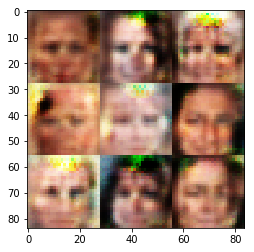

Epoch 2/3... Discriminator Loss: 1.0422... Generator Loss: 1.9211
Epoch 2/3... Discriminator Loss: 1.2493... Generator Loss: 0.8602
Epoch 2/3... Discriminator Loss: 1.2723... Generator Loss: 0.8339
Epoch 2/3... Discriminator Loss: 1.2406... Generator Loss: 0.8652
Epoch 2/3... Discriminator Loss: 1.2841... Generator Loss: 0.8661
Epoch 2/3... Discriminator Loss: 1.2239... Generator Loss: 0.8600
Epoch 2/3... Discriminator Loss: 1.2746... Generator Loss: 0.8017
Epoch 2/3... Discriminator Loss: 1.2039... Generator Loss: 0.8969
Epoch 2/3... Discriminator Loss: 1.3071... Generator Loss: 0.8052
Epoch 2/3... Discriminator Loss: 1.1897... Generator Loss: 0.7710


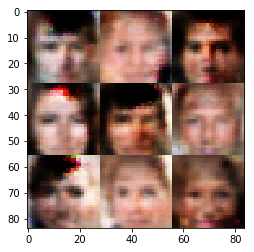

Epoch 2/3... Discriminator Loss: 1.2181... Generator Loss: 0.8603
Epoch 2/3... Discriminator Loss: 1.2203... Generator Loss: 0.8627
Epoch 2/3... Discriminator Loss: 1.2222... Generator Loss: 0.8707
Epoch 2/3... Discriminator Loss: 1.2734... Generator Loss: 0.8765
Epoch 2/3... Discriminator Loss: 1.2369... Generator Loss: 0.9374
Epoch 2/3... Discriminator Loss: 1.4179... Generator Loss: 0.6237
Epoch 2/3... Discriminator Loss: 1.2862... Generator Loss: 1.1164
Epoch 2/3... Discriminator Loss: 1.2519... Generator Loss: 1.2456
Epoch 2/3... Discriminator Loss: 1.2610... Generator Loss: 0.8108
Epoch 2/3... Discriminator Loss: 1.3324... Generator Loss: 0.7452


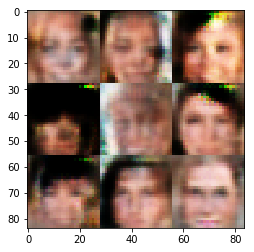

Epoch 2/3... Discriminator Loss: 1.2555... Generator Loss: 0.7784
Epoch 2/3... Discriminator Loss: 1.2736... Generator Loss: 0.7621
Epoch 2/3... Discriminator Loss: 1.3892... Generator Loss: 0.9956
Epoch 2/3... Discriminator Loss: 1.2546... Generator Loss: 0.8700
Epoch 2/3... Discriminator Loss: 1.2080... Generator Loss: 0.8744
Epoch 2/3... Discriminator Loss: 1.3528... Generator Loss: 0.8743
Epoch 2/3... Discriminator Loss: 1.2831... Generator Loss: 0.7637
Epoch 2/3... Discriminator Loss: 1.2433... Generator Loss: 0.9581
Epoch 2/3... Discriminator Loss: 1.3118... Generator Loss: 0.8671
Epoch 2/3... Discriminator Loss: 1.1869... Generator Loss: 0.9433


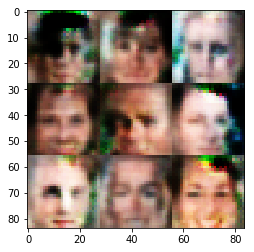

Epoch 2/3... Discriminator Loss: 1.2689... Generator Loss: 0.7731
Epoch 2/3... Discriminator Loss: 1.2819... Generator Loss: 0.8084
Epoch 2/3... Discriminator Loss: 1.3384... Generator Loss: 0.6949
Epoch 2/3... Discriminator Loss: 1.1732... Generator Loss: 1.0371
Epoch 2/3... Discriminator Loss: 1.1961... Generator Loss: 0.7997
Epoch 2/3... Discriminator Loss: 1.3889... Generator Loss: 0.7596
Epoch 2/3... Discriminator Loss: 1.1659... Generator Loss: 0.7484
Epoch 2/3... Discriminator Loss: 1.1991... Generator Loss: 0.8670
Epoch 2/3... Discriminator Loss: 1.1584... Generator Loss: 1.3441
Epoch 2/3... Discriminator Loss: 1.4085... Generator Loss: 0.6624


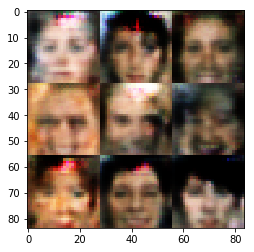

Epoch 2/3... Discriminator Loss: 1.2944... Generator Loss: 0.7019
Epoch 2/3... Discriminator Loss: 1.1771... Generator Loss: 0.8018
Epoch 2/3... Discriminator Loss: 1.2784... Generator Loss: 0.7635
Epoch 2/3... Discriminator Loss: 1.2815... Generator Loss: 0.7459
Epoch 2/3... Discriminator Loss: 1.2724... Generator Loss: 0.8840
Epoch 2/3... Discriminator Loss: 1.1849... Generator Loss: 0.9691
Epoch 2/3... Discriminator Loss: 1.1622... Generator Loss: 0.9763
Epoch 2/3... Discriminator Loss: 1.3022... Generator Loss: 0.8985
Epoch 2/3... Discriminator Loss: 1.2928... Generator Loss: 0.6821
Epoch 2/3... Discriminator Loss: 1.2522... Generator Loss: 0.8287


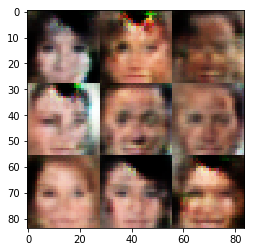

Epoch 2/3... Discriminator Loss: 1.3406... Generator Loss: 1.0252
Epoch 2/3... Discriminator Loss: 1.8962... Generator Loss: 0.2062
Epoch 2/3... Discriminator Loss: 1.3211... Generator Loss: 0.8795
Epoch 2/3... Discriminator Loss: 1.2562... Generator Loss: 0.9117
Epoch 2/3... Discriminator Loss: 1.3188... Generator Loss: 0.7638
Epoch 2/3... Discriminator Loss: 1.3021... Generator Loss: 0.7949
Epoch 2/3... Discriminator Loss: 1.2085... Generator Loss: 0.9274
Epoch 2/3... Discriminator Loss: 1.3688... Generator Loss: 0.6935
Epoch 2/3... Discriminator Loss: 1.3131... Generator Loss: 0.7815
Epoch 2/3... Discriminator Loss: 1.2994... Generator Loss: 0.7574


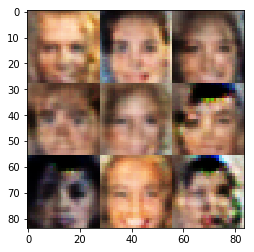

Epoch 2/3... Discriminator Loss: 1.2794... Generator Loss: 0.8934
Epoch 2/3... Discriminator Loss: 1.3121... Generator Loss: 0.7265
Epoch 2/3... Discriminator Loss: 1.3403... Generator Loss: 0.8840
Epoch 2/3... Discriminator Loss: 1.2405... Generator Loss: 0.9377
Epoch 2/3... Discriminator Loss: 1.2845... Generator Loss: 0.8263
Epoch 2/3... Discriminator Loss: 1.2615... Generator Loss: 0.8380
Epoch 2/3... Discriminator Loss: 1.2006... Generator Loss: 1.3746
Epoch 2/3... Discriminator Loss: 1.2914... Generator Loss: 0.8480
Epoch 2/3... Discriminator Loss: 1.2679... Generator Loss: 0.8765
Epoch 2/3... Discriminator Loss: 1.2486... Generator Loss: 0.9410


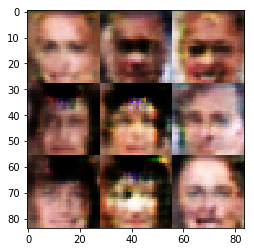

Epoch 2/3... Discriminator Loss: 1.3639... Generator Loss: 0.7725
Epoch 2/3... Discriminator Loss: 1.1912... Generator Loss: 0.9348
Epoch 2/3... Discriminator Loss: 1.3071... Generator Loss: 0.7426
Epoch 2/3... Discriminator Loss: 1.2526... Generator Loss: 0.9058
Epoch 2/3... Discriminator Loss: 1.1686... Generator Loss: 0.9331
Epoch 2/3... Discriminator Loss: 1.2738... Generator Loss: 0.7214
Epoch 3/3... Discriminator Loss: 1.2977... Generator Loss: 0.7537
Epoch 3/3... Discriminator Loss: 1.3940... Generator Loss: 0.6342
Epoch 3/3... Discriminator Loss: 1.3327... Generator Loss: 0.7604
Epoch 3/3... Discriminator Loss: 1.2438... Generator Loss: 1.0885


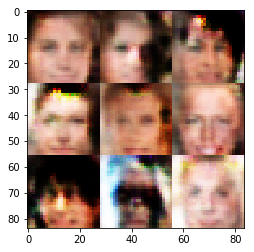

Epoch 3/3... Discriminator Loss: 1.2749... Generator Loss: 0.8097
Epoch 3/3... Discriminator Loss: 1.2468... Generator Loss: 0.8622
Epoch 3/3... Discriminator Loss: 1.3700... Generator Loss: 0.7289
Epoch 3/3... Discriminator Loss: 1.2113... Generator Loss: 0.9089
Epoch 3/3... Discriminator Loss: 1.1793... Generator Loss: 0.9166
Epoch 3/3... Discriminator Loss: 1.3217... Generator Loss: 0.6667
Epoch 3/3... Discriminator Loss: 1.2432... Generator Loss: 1.0570
Epoch 3/3... Discriminator Loss: 1.3293... Generator Loss: 0.7716
Epoch 3/3... Discriminator Loss: 1.2577... Generator Loss: 0.9071
Epoch 3/3... Discriminator Loss: 1.2471... Generator Loss: 0.8370


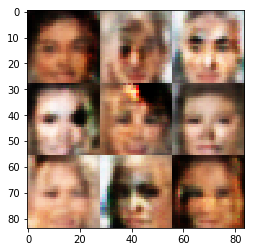

Epoch 3/3... Discriminator Loss: 1.3258... Generator Loss: 0.8381
Epoch 3/3... Discriminator Loss: 1.2100... Generator Loss: 1.0014
Epoch 3/3... Discriminator Loss: 1.2026... Generator Loss: 0.8443
Epoch 3/3... Discriminator Loss: 1.2166... Generator Loss: 0.8919
Epoch 3/3... Discriminator Loss: 1.2891... Generator Loss: 0.6964
Epoch 3/3... Discriminator Loss: 1.1256... Generator Loss: 1.3702
Epoch 3/3... Discriminator Loss: 1.3767... Generator Loss: 1.1168
Epoch 3/3... Discriminator Loss: 1.1746... Generator Loss: 1.0098
Epoch 3/3... Discriminator Loss: 1.2439... Generator Loss: 0.7833
Epoch 3/3... Discriminator Loss: 1.2806... Generator Loss: 0.8147


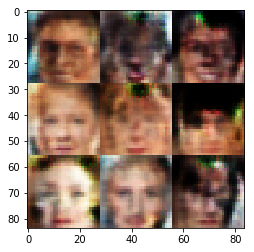

Epoch 3/3... Discriminator Loss: 1.1242... Generator Loss: 0.9338
Epoch 3/3... Discriminator Loss: 1.2356... Generator Loss: 1.1316
Epoch 3/3... Discriminator Loss: 1.2303... Generator Loss: 0.6809
Epoch 3/3... Discriminator Loss: 1.4202... Generator Loss: 0.9937
Epoch 3/3... Discriminator Loss: 1.1596... Generator Loss: 0.8095
Epoch 3/3... Discriminator Loss: 1.2391... Generator Loss: 0.8440
Epoch 3/3... Discriminator Loss: 1.3097... Generator Loss: 0.8849
Epoch 3/3... Discriminator Loss: 1.3450... Generator Loss: 0.7292
Epoch 3/3... Discriminator Loss: 1.1909... Generator Loss: 0.8460
Epoch 3/3... Discriminator Loss: 1.2907... Generator Loss: 0.8300


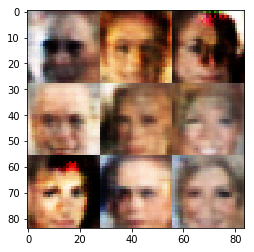

Epoch 3/3... Discriminator Loss: 1.3193... Generator Loss: 0.8476
Epoch 3/3... Discriminator Loss: 1.3528... Generator Loss: 0.8141
Epoch 3/3... Discriminator Loss: 1.2090... Generator Loss: 0.9333
Epoch 3/3... Discriminator Loss: 1.1993... Generator Loss: 0.8913
Epoch 3/3... Discriminator Loss: 1.2808... Generator Loss: 0.8127
Epoch 3/3... Discriminator Loss: 1.2571... Generator Loss: 0.9686
Epoch 3/3... Discriminator Loss: 1.2206... Generator Loss: 0.8696
Epoch 3/3... Discriminator Loss: 1.3220... Generator Loss: 0.7144
Epoch 3/3... Discriminator Loss: 1.2212... Generator Loss: 0.9529
Epoch 3/3... Discriminator Loss: 1.2031... Generator Loss: 1.2392


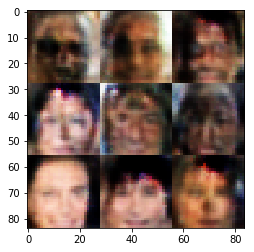

Epoch 3/3... Discriminator Loss: 1.2930... Generator Loss: 0.9023
Epoch 3/3... Discriminator Loss: 1.2726... Generator Loss: 1.0765
Epoch 3/3... Discriminator Loss: 1.2423... Generator Loss: 0.8989
Epoch 3/3... Discriminator Loss: 1.2153... Generator Loss: 0.8223
Epoch 3/3... Discriminator Loss: 1.2826... Generator Loss: 0.7418
Epoch 3/3... Discriminator Loss: 1.2104... Generator Loss: 0.8232
Epoch 3/3... Discriminator Loss: 1.1723... Generator Loss: 1.0242
Epoch 3/3... Discriminator Loss: 1.2156... Generator Loss: 0.9020
Epoch 3/3... Discriminator Loss: 1.2613... Generator Loss: 0.8760
Epoch 3/3... Discriminator Loss: 1.3574... Generator Loss: 0.7804


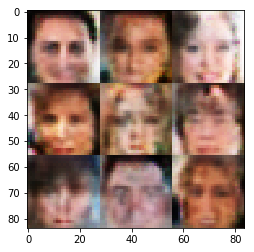

Epoch 3/3... Discriminator Loss: 1.2162... Generator Loss: 1.3082
Epoch 3/3... Discriminator Loss: 1.1859... Generator Loss: 1.1929
Epoch 3/3... Discriminator Loss: 1.2002... Generator Loss: 0.9372
Epoch 3/3... Discriminator Loss: 1.2543... Generator Loss: 0.9249
Epoch 3/3... Discriminator Loss: 1.3418... Generator Loss: 0.7931
Epoch 3/3... Discriminator Loss: 1.1090... Generator Loss: 1.2562
Epoch 3/3... Discriminator Loss: 1.4301... Generator Loss: 0.4712
Epoch 3/3... Discriminator Loss: 1.3391... Generator Loss: 0.8507
Epoch 3/3... Discriminator Loss: 1.2409... Generator Loss: 0.8246
Epoch 3/3... Discriminator Loss: 1.2068... Generator Loss: 0.7939


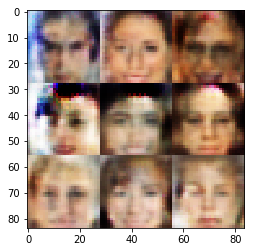

Epoch 3/3... Discriminator Loss: 1.2564... Generator Loss: 0.7900
Epoch 3/3... Discriminator Loss: 1.2783... Generator Loss: 0.8945
Epoch 3/3... Discriminator Loss: 1.2849... Generator Loss: 0.7648
Epoch 3/3... Discriminator Loss: 1.3024... Generator Loss: 0.7316
Epoch 3/3... Discriminator Loss: 1.2507... Generator Loss: 0.8310
Epoch 3/3... Discriminator Loss: 1.1613... Generator Loss: 1.2674
Epoch 3/3... Discriminator Loss: 1.2219... Generator Loss: 0.9403
Epoch 3/3... Discriminator Loss: 1.3178... Generator Loss: 0.8071
Epoch 3/3... Discriminator Loss: 1.2899... Generator Loss: 0.8165
Epoch 3/3... Discriminator Loss: 1.2853... Generator Loss: 0.7504


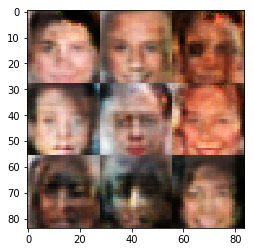

Epoch 3/3... Discriminator Loss: 1.2600... Generator Loss: 0.8645
Epoch 3/3... Discriminator Loss: 1.3272... Generator Loss: 0.8171
Epoch 3/3... Discriminator Loss: 1.2887... Generator Loss: 0.8541
Epoch 3/3... Discriminator Loss: 1.0984... Generator Loss: 1.2913
Epoch 3/3... Discriminator Loss: 1.3360... Generator Loss: 0.7835
Epoch 3/3... Discriminator Loss: 1.2141... Generator Loss: 0.8174
Epoch 3/3... Discriminator Loss: 1.2544... Generator Loss: 0.7662
Epoch 3/3... Discriminator Loss: 1.3782... Generator Loss: 0.7829
Epoch 3/3... Discriminator Loss: 1.2259... Generator Loss: 0.8133
Epoch 3/3... Discriminator Loss: 1.3570... Generator Loss: 0.9614


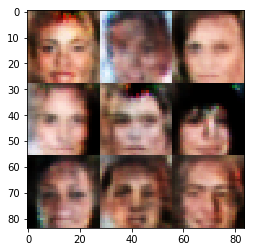

Epoch 3/3... Discriminator Loss: 1.2985... Generator Loss: 0.8764
Epoch 3/3... Discriminator Loss: 1.3866... Generator Loss: 0.9961
Epoch 3/3... Discriminator Loss: 1.1862... Generator Loss: 1.0206
Epoch 3/3... Discriminator Loss: 1.3644... Generator Loss: 0.8595
Epoch 3/3... Discriminator Loss: 1.2252... Generator Loss: 0.8451
Epoch 3/3... Discriminator Loss: 1.2791... Generator Loss: 0.9702
Epoch 3/3... Discriminator Loss: 1.3093... Generator Loss: 0.8086
Epoch 3/3... Discriminator Loss: 1.2137... Generator Loss: 1.0566
Epoch 3/3... Discriminator Loss: 1.3530... Generator Loss: 0.8965
Epoch 3/3... Discriminator Loss: 1.2914... Generator Loss: 0.8005


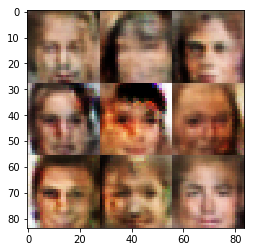

Epoch 3/3... Discriminator Loss: 1.2846... Generator Loss: 0.9110
Epoch 3/3... Discriminator Loss: 1.3219... Generator Loss: 1.0454
Epoch 3/3... Discriminator Loss: 1.3159... Generator Loss: 0.6943
Epoch 3/3... Discriminator Loss: 1.2986... Generator Loss: 0.7631
Epoch 3/3... Discriminator Loss: 1.2891... Generator Loss: 0.8856
Epoch 3/3... Discriminator Loss: 1.3085... Generator Loss: 0.7755
Epoch 3/3... Discriminator Loss: 1.1416... Generator Loss: 0.8623
Epoch 3/3... Discriminator Loss: 1.3666... Generator Loss: 0.8211
Epoch 3/3... Discriminator Loss: 1.2992... Generator Loss: 0.8034
Epoch 3/3... Discriminator Loss: 1.2327... Generator Loss: 0.7863


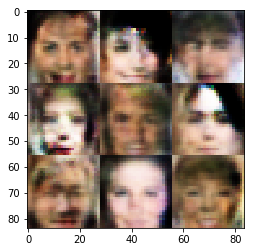

Epoch 3/3... Discriminator Loss: 1.3448... Generator Loss: 0.8950
Epoch 3/3... Discriminator Loss: 1.2727... Generator Loss: 1.1898
Epoch 3/3... Discriminator Loss: 1.2283... Generator Loss: 1.1132
Epoch 3/3... Discriminator Loss: 1.3088... Generator Loss: 0.8045
Epoch 3/3... Discriminator Loss: 1.2345... Generator Loss: 0.8264
Epoch 3/3... Discriminator Loss: 1.2094... Generator Loss: 0.9118
Epoch 3/3... Discriminator Loss: 1.3175... Generator Loss: 0.6391
Epoch 3/3... Discriminator Loss: 1.4742... Generator Loss: 0.9120
Epoch 3/3... Discriminator Loss: 1.2784... Generator Loss: 0.9334
Epoch 3/3... Discriminator Loss: 1.2952... Generator Loss: 0.7911


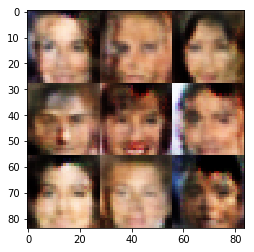

Epoch 3/3... Discriminator Loss: 1.3132... Generator Loss: 0.7599
Epoch 3/3... Discriminator Loss: 1.2928... Generator Loss: 1.0578
Epoch 3/3... Discriminator Loss: 1.3248... Generator Loss: 0.9250
Epoch 3/3... Discriminator Loss: 1.3771... Generator Loss: 0.8789
Epoch 3/3... Discriminator Loss: 1.1967... Generator Loss: 0.7941
Epoch 3/3... Discriminator Loss: 1.1452... Generator Loss: 1.3216
Epoch 3/3... Discriminator Loss: 1.2866... Generator Loss: 0.7720
Epoch 3/3... Discriminator Loss: 1.2117... Generator Loss: 0.9441
Epoch 3/3... Discriminator Loss: 1.2784... Generator Loss: 0.9209
Epoch 3/3... Discriminator Loss: 1.2824... Generator Loss: 1.0025


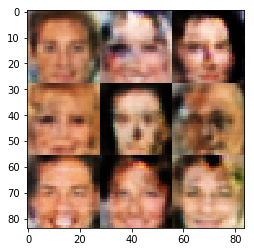

Epoch 3/3... Discriminator Loss: 1.3022... Generator Loss: 0.8833
Epoch 3/3... Discriminator Loss: 1.2755... Generator Loss: 0.8750
Epoch 3/3... Discriminator Loss: 1.3349... Generator Loss: 0.6713
Epoch 3/3... Discriminator Loss: 1.3795... Generator Loss: 0.9698
Epoch 3/3... Discriminator Loss: 1.1928... Generator Loss: 0.9387
Epoch 3/3... Discriminator Loss: 1.3426... Generator Loss: 0.8281
Epoch 3/3... Discriminator Loss: 1.3168... Generator Loss: 0.8491
Epoch 3/3... Discriminator Loss: 1.2969... Generator Loss: 0.8604
Epoch 3/3... Discriminator Loss: 1.2569... Generator Loss: 0.9297
Epoch 3/3... Discriminator Loss: 1.2497... Generator Loss: 0.9620


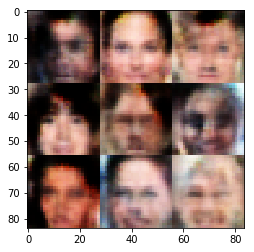

Epoch 3/3... Discriminator Loss: 1.4298... Generator Loss: 0.7467
Epoch 3/3... Discriminator Loss: 1.2829... Generator Loss: 0.8645
Epoch 3/3... Discriminator Loss: 1.3989... Generator Loss: 0.8469
Epoch 3/3... Discriminator Loss: 1.3565... Generator Loss: 0.6264
Epoch 3/3... Discriminator Loss: 1.2386... Generator Loss: 0.9305
Epoch 3/3... Discriminator Loss: 1.0696... Generator Loss: 1.2644
Epoch 3/3... Discriminator Loss: 1.2875... Generator Loss: 0.9608
Epoch 3/3... Discriminator Loss: 1.2906... Generator Loss: 1.0865
Epoch 3/3... Discriminator Loss: 1.2348... Generator Loss: 0.8139
Epoch 3/3... Discriminator Loss: 1.3354... Generator Loss: 0.9622


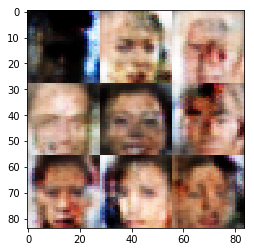

Epoch 3/3... Discriminator Loss: 1.2964... Generator Loss: 0.8040
Epoch 3/3... Discriminator Loss: 1.3018... Generator Loss: 0.9054
Epoch 3/3... Discriminator Loss: 1.2229... Generator Loss: 0.7936
Epoch 3/3... Discriminator Loss: 1.3644... Generator Loss: 0.9687
Epoch 3/3... Discriminator Loss: 1.2764... Generator Loss: 1.0055
Epoch 3/3... Discriminator Loss: 1.3148... Generator Loss: 0.8179
Epoch 3/3... Discriminator Loss: 1.3816... Generator Loss: 0.9340
Epoch 3/3... Discriminator Loss: 1.2200... Generator Loss: 0.8957
Epoch 3/3... Discriminator Loss: 1.3601... Generator Loss: 0.8584
Epoch 3/3... Discriminator Loss: 1.1934... Generator Loss: 1.0619


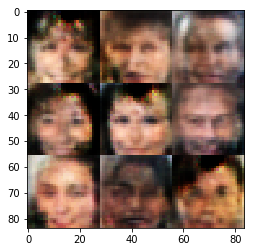

Epoch 3/3... Discriminator Loss: 1.2347... Generator Loss: 0.9122
Epoch 3/3... Discriminator Loss: 1.3443... Generator Loss: 0.7559
Epoch 3/3... Discriminator Loss: 1.2195... Generator Loss: 0.9184
Epoch 3/3... Discriminator Loss: 1.2531... Generator Loss: 0.7727


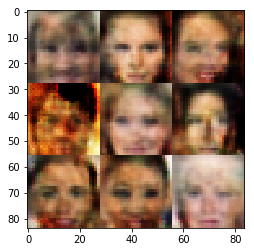

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.